## Notebook setup

In [15]:
import bz2
import csv
import json
import os
import random
import sys

import fasttext
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
csv.field_size_limit(sys.maxsize)

131072

In [5]:
HDFS_DIR = 'all-outlinks-by-article'
STAT_DIR = f'./{HDFS_DIR}'
if not os.path.exists(STAT_DIR):
    print(f"{STAT_DIR} does not exist.")
OUTPUT_DIR = './fasttext_data/202012/'
if not os.path.exists(OUTPUT_DIR):
    print(f"{OUTPUT_DIR} does not exist.")
OUTPUT_BASE = 'wikiworkshop_202012'
LABELED_DATA_URL = 'https://ndownloader.figshare.com/files/22969217'
LABELED_DATA_FN = os.path.join(OUTPUT_DIR, 'labeled_enwiki_with_topics_metadata.json.bz2')
TRAIN_PROP = 0.9
VAL_PROP = 0.02
TEST_PROP = 0.08
assert TRAIN_PROP + VAL_PROP + TEST_PROP == 1

In [6]:
!hdfs dfs -copyToLocal '{HDFS_DIR}/part*' '{STAT_DIR}'

In [8]:
!du -hs '{STAT_DIR}'

8.4G	./all-outlinks-by-article


## Gather labels

In [27]:
# If getting from Figshare
!wget {LABELED_DATA_URL} -O {LABELED_DATA_FN}

--2020-10-14 20:22:34--  https://ndownloader.figshare.com/files/22969217
Resolving webproxy.eqiad.wmnet (webproxy.eqiad.wmnet)... 2620:0:861:1:208:80:154:32, 208.80.154.32
Connecting to webproxy.eqiad.wmnet (webproxy.eqiad.wmnet)|2620:0:861:1:208:80:154:32|:8080... connected.
Proxy request sent, awaiting response... 302 Found
Location: https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/22969217/labeled_enwiki_with_topics_metadata.json.bz2 [following]
--2020-10-14 20:22:35--  https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/22969217/labeled_enwiki_with_topics_metadata.json.bz2
Connecting to webproxy.eqiad.wmnet (webproxy.eqiad.wmnet)|2620:0:861:1:208:80:154:32|:8080... connected.
Proxy request sent, awaiting response... 200 OK
Length: 316930407 (302M) [application/octet-stream]
Saving to: ‘./fasttext_data/labeled_enwiki_with_topics_metadata.json.bz2’

./fasttext_data/lab 100%[===================>] 302.25M  17.3MB/s    in 19s     

2020-10-14 20:22:55 (15.7 MB/s) - ‘./fasttext_data

In [10]:
qid_to_topics = {}
articles_per_topic = {}
topic_dist = {}
skipped = 0
no_topics = 0
with bz2.open(LABELED_DATA_FN, 'rt') as fin:
    for line in fin:
        line = json.loads(line)
        qid = line.get('qid')
        topics = line['topics']
        if qid:
            if topics:
                topic_dist[len(topics)] = topic_dist.get(len(topics), 0) + 1
                qid_to_topics[qid] = topics
                for t in topics:
                    articles_per_topic[t] = articles_per_topic.get(t, 0) + 1
            else:
                no_topics += 1
        else:
            skipped += 1
print("{0} QIDs, {1} skipped bc no topics, and {2} w/o QIDs.".format(len(qid_to_topics), no_topics, skipped))

5662388 QIDs, 268583 skipped bc no topics, and 39627 w/o QIDs.


Distribution of # of topics per article


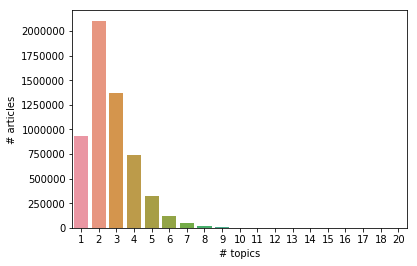

In [11]:
print("Distribution of # of topics per article")
topic_dist_df = pd.DataFrame({'# articles':[v for v in topic_dist.values()], '# topics':[k for k in topic_dist.keys()]})
#topic_dist_df.columns = ['# Topics','# Articles']
sns.barplot(data=topic_dist_df, x='# topics', y='# articles')

In [20]:
md = None
for i, t in enumerate(sorted(articles_per_topic, key=articles_per_topic.get), start=1):
    print(f"{i}. {t}:\t{articles_per_topic[t]} articles")
    if i == int(len(articles_per_topic) / 2):
        md = articles_per_topic[t]
    
print(f"\nAverage: {sum(articles_per_topic.values()) / len(articles_per_topic)}")
print(f"Median: {md}")

1. STEM.Libraries & Information:	10043 articles
2. Geography.Regions.Africa.Central Africa:	11794 articles
3. Geography.Regions.Asia.Central Asia:	11966 articles
4. Culture.Visual arts.Fashion:	12730 articles
5. STEM.Physics:	19388 articles
6. Culture.Media.Software:	23504 articles
7. STEM.Mathematics:	24001 articles
8. Geography.Regions.Africa.Southern Africa:	27049 articles
9. Culture.Media.Radio:	29252 articles
10. STEM.Chemistry:	30155 articles
11. Geography.Regions.Africa.Northern Africa:	31563 articles
12. STEM.Space:	33451 articles
13. Geography.Regions.Africa.Eastern Africa:	36411 articles
14. Culture.Visual arts.Comics and Anime:	37144 articles
15. Geography.Regions.Africa.Western Africa:	37305 articles
16. Culture.Media.Video games:	37399 articles
17. Culture.Food and drink:	37510 articles
18. Culture.Performing arts:	41835 articles
19. STEM.Computing:	46064 articles
20. Culture.Internet culture:	49292 articles
21. Geography.Regions.Americas.Central America:	54149 articles
22

## Convert data to fastText format

In [21]:
def fasttextify(topic):
    """Translate articletopic labels into fastText format (prefixed with __label__ and no spaces)."""
    return '__label__{0}'.format(topic.replace(' ', '_'))

In [22]:
train_fn = os.path.join(OUTPUT_DIR, '{0}_train.txt'.format(OUTPUT_BASE))
train_metadata_fn = os.path.join(OUTPUT_DIR, '{0}_train_metadata.txt'.format(OUTPUT_BASE))
val_fn = os.path.join(OUTPUT_DIR, '{0}_val.txt'.format(OUTPUT_BASE))
val_metadata_fn = os.path.join(OUTPUT_DIR, '{0}_val_metadata.txt'.format(OUTPUT_BASE))
test_fn = os.path.join(OUTPUT_DIR, '{0}_test.txt'.format(OUTPUT_BASE))
test_metadata_fn = os.path.join(OUTPUT_DIR, '{0}_test_metadata.txt'.format(OUTPUT_BASE))
nogroundtruth_fn = os.path.join(OUTPUT_DIR, '{0}_nogt.txt'.format(OUTPUT_BASE))
nogroundtruth_metadata_fn = os.path.join(OUTPUT_DIR, '{0}_nogt_metadata.txt'.format(OUTPUT_BASE))
train_written = 0
val_written = 0
test_written = 0
nogt_written = 0
i = 0
qids_to_split = {}
tsvs = [fn for fn in os.listdir(STAT_DIR) if fn.endswith('.csv.bz2')]
print_every = 1
with open(train_fn, 'w') as train_fout:
    with open(train_metadata_fn, 'w') as train_metadata_fout:
        with open(val_fn, 'w') as val_fout:
            with open(val_metadata_fn, 'w') as val_metadata_fout:
                with open(test_fn, 'w') as test_fout:
                    with open(test_metadata_fn, 'w') as test_metadata_fout:
                        with open(nogroundtruth_fn, 'w') as nogt_fout:
                            with open(nogroundtruth_metadata_fn, 'w') as nogt_metadata_fout:
                                for fidx, fn in enumerate(tsvs, start=1):
                                    with bz2.open(os.path.join(STAT_DIR, fn), 'rt') as fin:
                                        tsvreader = csv.reader(fin, delimiter='\t')
                                        assert next(tsvreader) == ['wiki_db', 'pid_from', 'qid_from', 'outlinks']
                                        for i, line in enumerate(tsvreader, start=1):
                                            wiki_db = line[0]
                                            pid = line[1]
                                            src_qid = line[2]
                                            topics = qid_to_topics.get(src_qid, [])
                                            outlinks = line[3].split()
                                            random.shuffle(outlinks)  # randomize order for training
                                            if topics:
                                                if src_qid in qids_to_split:
                                                    r = qids_to_split[src_qid]
                                                else:
                                                    r = random.random()
                                                    qids_to_split[src_qid] = r
                                                if r <= TRAIN_PROP:
                                                    data_fout = train_fout
                                                    metadata_fout = train_metadata_fout
                                                    train_written += 1
                                                elif r <= TRAIN_PROP + VAL_PROP:
                                                    data_fout = val_fout
                                                    metadata_fout = val_metadata_fout
                                                    val_written += 1
                                                else:
                                                    data_fout = test_fout
                                                    metadata_fout = test_metadata_fout
                                                    test_written += 1
                                            else:
                                                data_fout = nogt_fout
                                                metadata_fout = nogt_metadata_fout
                                                nogt_written += 1
                                            data_fout.write('{0} {1}\n'.format(' '.join([fasttextify(t) for t in topics]), ' '.join(outlinks)))
                                            metadata_fout.write('{0}\t{1}\t{2}\n'.format(src_qid, wiki_db, pid))
                                    if fidx % print_every == 0:
                                        print_every *= 2
                                        print("{0} of {1} processed: {2} train. {3} val. {4} test. {5} no groundtruth.".format(fidx, len(tsvs),
                                                                                                                                   train_written,
                                                                                                                                   val_written,
                                                                                                                                   test_written,
                                                                                                                                   nogt_written))

print("{0} of {1} processed: {2} train. {3} val. {4} test. {5} no groundtruth.".format(fidx, len(tsvs), train_written, val_written, test_written, nogt_written))

1 of 1024 processed: 26727 train. 590 val. 2371 test. 24520 no groundtruth.
2 of 1024 processed: 53110 train. 1163 val. 4640 test. 48785 no groundtruth.
4 of 1024 processed: 106233 train. 2368 val. 9222 test. 97350 no groundtruth.
8 of 1024 processed: 212480 train. 4718 val. 18569 test. 195620 no groundtruth.
16 of 1024 processed: 425379 train. 9407 val. 37513 test. 391495 no groundtruth.
32 of 1024 processed: 849489 train. 18923 val. 75576 test. 783075 no groundtruth.
64 of 1024 processed: 1701246 train. 37948 val. 151181 test. 1565414 no groundtruth.
128 of 1024 processed: 3403591 train. 75535 val. 302215 test. 3131642 no groundtruth.
256 of 1024 processed: 6804845 train. 150683 val. 605271 test. 6263314 no groundtruth.
512 of 1024 processed: 13610271 train. 301592 val. 1208861 test. 12521250 no groundtruth.
1024 of 1024 processed: 27225747 train. 603582 val. 2417700 test. 25047098 no groundtruth.
1024 of 1024 processed: 27225747 train. 603582 val. 2417700 test. 25047098 no groundtru

In [26]:
print('Train:\t', len([0 for v in qids_to_split.values() if v <= TRAIN_PROP]))
print('Val:\t', len([0 for v in qids_to_split.values() if v > TRAIN_PROP and v <= TRAIN_PROP + VAL_PROP]))
print('Test:\t', len([0 for v in qids_to_split.values() if v > TRAIN_PROP + VAL_PROP]))

Train:	 5088621
Val:	 113241
Test:	 451909


## Train Model
See: stat1007:/home/isaacj/lang_agnostic_topic_modeling/topics/train_fasttext_topic_classification.py

In [28]:
model_dir = './fasttext_data/202012/'
model_prefix = 'model_alloutlinks_202012'
OUTPUT_MODEL = os.path.join(model_dir, f'{model_prefix}.bin')
EVAL_TSV = os.path.join(model_dir, f'{model_prefix}_eval.tsv')
RESULTS_WIKI_TSV = os.path.join(model_dir, f'{model_prefix}_wikidb.tsv')
RESULTS_OUTLINK_TSV = os.path.join(model_dir, f'{model_prefix}_outlink.tsv')
PREDICTIONS_TSV = os.path.join(model_dir, f'{model_prefix}_predictions.tsv.bz2')
LANG_PROBS_TSV = os.path.join(model_dir, f'{model_prefix}_wiki_topic_dist.tsv')

In [ ]:
!python train_fasttext_topic_classification.py \
  --training_data {train_fn} \
  --val_data {val_fn} \
  --test_data {test_fn} \
  --output_model {OUTPUT_MODEL} \
  --false_negatives_fn '' \
  --word_vectors '' \
  --learning_rates 0.1 \
  --minCounts 5 10 20 \
  --epochs 2 3 \
  --ws 20 \
  --ndims 50 100 \
  --mlc_res_tsv {EVAL_TSV}

## Apply Model
Skipping:
  --wikidb_wikitext RESULTS_WIKI_TSV \
  --outlink_wikitext RESULTS_OUTLINK_TSV
  --labeled_qids


In [ ]:
!python bulk_predict.py \
  --collected_outlinks_tsvs {STAT_DIR} \
  --output_predictions_tsv {PREDICTIONS_TSV} \
  --output_lang_data {LANG_PROBS_TSV} \
  --model_bin {OUTPUT_MODEL}

/usr/lib/python3/dist-packages/sklearn/externals/joblib.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp

Model architecture:
Embedding size: 50
Total # params: 3200
Vocab size: 5241513
File size: 1090.587 MB
File 1/1024. 53128 total lines processed. Top 5 wiki_dbs: [('enwiki', 6036), ('cebwiki', 5245), ('svwiki', 3687), ('dewiki', 2465), ('frwiki', 2177)]
File 2/1024. 105991 total lines processed. Top 5 wiki_dbs: [('enwiki', 12031), ('cebwiki', 10432), ('svwiki', 7229), ('dewiki', 5018), ('frwiki', 4398)]
File 3/1024. 159322 total lines processed. Top 5 wiki_dbs: [('enwiki', 17946), ('cebwiki', 15732), ('svwiki', 10816), ('dewiki', 7473), ('frwiki', 6618)]


In [ ]:
for_hive_tsv = './fasttext_data/model_alloutlinks_202009_predictions_hive.tsv'
expected_header = ['wiki_db', 'qid', 'pid', 'num_outlinks',
                   'Culture.Biography.Biography*', 'Culture.Biography.Women',
                   'Culture.Food_and_drink',
                   'Culture.Internet_culture',
                   'Culture.Linguistics',
                   'Culture.Literature',
                   'Culture.Media.Books', 'Culture.Media.Entertainment', 'Culture.Media.Films', 'Culture.Media.Media*', 'Culture.Media.Music', 'Culture.Media.Radio', 'Culture.Media.Software', 'Culture.Media.Television', 'Culture.Media.Video_games',
                   'Culture.Performing_arts',
                   'Culture.Philosophy_and_religion',
                   'Culture.Sports',
                   'Culture.Visual_arts.Architecture', 'Culture.Visual_arts.Comics_and_Anime', 'Culture.Visual_arts.Fashion', 'Culture.Visual_arts.Visual_arts*',
                   'Geography.Geographical',
                   'Geography.Regions.Africa.Africa*', 'Geography.Regions.Africa.Central_Africa', 'Geography.Regions.Africa.Eastern_Africa', 'Geography.Regions.Africa.Northern_Africa', 'Geography.Regions.Africa.Southern_Africa', 'Geography.Regions.Africa.Western_Africa',
                   'Geography.Regions.Americas.Central_America', 'Geography.Regions.Americas.North_America', 'Geography.Regions.Americas.South_America',
                   'Geography.Regions.Asia.Asia*', 'Geography.Regions.Asia.Central_Asia', 'Geography.Regions.Asia.East_Asia', 'Geography.Regions.Asia.North_Asia', 'Geography.Regions.Asia.South_Asia', 'Geography.Regions.Asia.Southeast_Asia', 'Geography.Regions.Asia.West_Asia',
                   'Geography.Regions.Europe.Eastern_Europe', 'Geography.Regions.Europe.Europe*', 'Geography.Regions.Europe.Northern_Europe', 'Geography.Regions.Europe.Southern_Europe', 'Geography.Regions.Europe.Western_Europe',
                   'Geography.Regions.Oceania',
                   'History_and_Society.Business_and_economics',
                   'History_and_Society.Education',
                   'History_and_Society.History',
                   'History_and_Society.Military_and_warfare',
                   'History_and_Society.Politics_and_government',
                   'History_and_Society.Society',
                   'History_and_Society.Transportation',
                   'STEM.Biology',
                   'STEM.Chemistry',
                   'STEM.Computing',
                   'STEM.Earth_and_environment',
                   'STEM.Engineering',
                   'STEM.Libraries_&_Information',
                   'STEM.Mathematics',
                   'STEM.Medicine_&_Health',
                   'STEM.Physics',
                   'STEM.STEM*',
                   'STEM.Space',
                   'STEM.Technology']
topic_start_idx = expected_header.index('Culture.Biography.Biography*')
topic_end_idx = expected_header.index('STEM.Technology')
wikidb_idx = expected_header.index('wiki_db')
pid_idx = expected_header.index('pid')
qid_idx = expected_header.index('qid')
threshold = 0.15
written = 0
with open(for_hive_tsv, 'w') as fout:
    # fout.write('pageid\tqid\ttopic\tscore\twikidb\n')
    with bz2.open(PREDICTIONS_TSV, 'rt') as fin:
        tsvreader = csv.reader(fin, delimiter='\t')
        assert next(tsvreader) == expected_header
        for i, line in enumerate(tsvreader, start=1):
            wiki = line[wikidb_idx]
            pid = int(line[pid_idx])
            qid = line[qid_idx]
            for idx in range(topic_start_idx, topic_end_idx + 1):
                if float(line[idx]) > threshold:
                    topic = expected_header[idx]
                    fout.write('{0}\t{1}\t{2}\t{3}\t{4}\n'.format(pid, qid, topic, line[idx], wiki))
                    written += 1
            if i % 1000000 == 0:
                print("{0} lines processed. Retained: {1}.".format(i, written))

In [13]:
print("{0} lines processed. Retained: {1}.".format(i, written))

54511389 lines processed. Retained: 178970191.
